In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl
from matplotlib.ticker import FormatStrFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import m2lib22.box as box
import m2lib22.aviso as aviso
import m2lib22.cstes as cstes
import m2lib22.diagnosis as diag
import m2lib22.erastar as eras
import m2lib22.stress_to_windterm as stw

from math import ceil
from m2lib22.cstes import labels, zarr_dir

plt.rcParams.update({'font.size':15})

In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    w = cluster.scale(jobs=1)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

<Client: 'tcp://10.148.0.106:59770' processes=0 threads=0, memory=0 B>

## IMPORT DATA, build dataset
We choose to get only erastar wind term, and we reject PEACHY data, and we select only deltaT<1H

In [3]:
dl=5
min_coloc_bin = 50

#PDFs
zarr = os.path.join(zarr_dir, f"pdf_lonlat_bin{dl}_sentinel_saral_gps.zarr")
dss = xr.open_zarr(zarr).persist()
#Mean var std rms
zarr = os.path.join(zarr_dir, f"stat_lonlat_bin{dl}_lim{min_coloc_bin}_sentinel_saral_gps.zarr")
ds = xr.open_zarr(zarr).persist()


Text(0.5, 0.98, 'Number of colocalisation per bins of 5°')

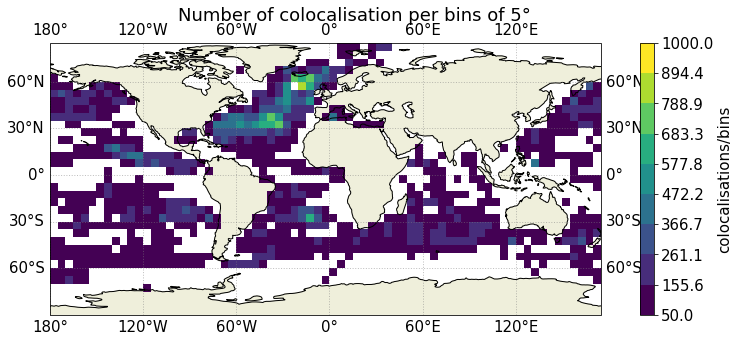

In [4]:
#import matplotlib.ticker as mticker

fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ds.nb_coloc_bins.plot(x='lon_bin', y='lat_bin', cmap='viridis', levels=10, ax=ax, vmin=min_coloc_bin, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
#gl.xlabels_top = False
#gl.ylabels_left = False
#gl.xlines = False
#gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
#gl.xformatter = LONGITUDE_FORMATTER
#gl.yformatter = LATITUDE_FORMATTER

fig.suptitle(f'Number of colocalisation per bins of {dl}°')

In [12]:
ds

<xarray.Dataset>
Dimensions:                                                         (
                                                                     id_comb: 36,
                                                                     lat_bin: 35,
                                                                     lon_bin: 71)
Coordinates:
  * id_comb                                                         (id_comb) <U44 ...
  * lat_bin                                                         (lat_bin) float64 ...
  * lon_bin                                                         (lon_bin) float64 ...
Data variables: (12/926)
    mean_alti_adt_g_grad_x                                          (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>
    mean_alti_adt_oceantide_dac_g_grad_x                            (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>
    mean_alti_adt_oceantide_g_grad_x                                (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>
    mean_alti_denoised_g_grad_x                                     (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>
    mean_alti_g_grad_x                                              (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>
    mean_aviso_alti_adt_g_grad_x                                    (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>
    ...                                                              ...
    var_sum_co_denoised_es_cstrio_z15_alti_x                        (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>
    var_sum_co_denoised_es_cstrio_z15_drifter_x                     (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>
    var_sum_co_es_cstrio_z0_alti_x                                  (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>
    var_sum_co_es_cstrio_z0_drifter_x                               (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>
    var_sum_co_es_cstrio_z15_alti_x                                 (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>
    var_sum_co_es_cstrio_z15_drifter_x                              (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>

# LON LAT bins

In [6]:
def plot_stat_lonlat(variables, ds=1, cmap='viridis', title =1 , cmap_label =1 ,fig_title=1,**kwargs):
    lv = len(variables)
    if isinstance(variables[0],str):
        variables = [ds[v] for v in variables]
        if isinstance(ds, int) : 
            assert False, 'give dataset'
    nrows = ceil(lv/2)
    ncols = 2
    if lv == 1:
        nrows = 1
        ncols = 1
    # Define the figure and each axis for the 3 rows and 3 columns
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(15,nrows*4))

    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    if lv !=1:
        axs=axs.flatten()
    else : axs = [axs]

    #Loop over all of the variables
    for i in range(lv):

            # Contour plot
            if cmap_label != 1:
                variables[i].assign_attrs({'long_name':cmap_label[i]}).plot(x='lon_bin', y='lat_bin', cmap=cmap, ax=axs[i],**kwargs)

            else : 
                variables[i].plot(x='lon_bin', y='lat_bin', cmap=cmap, ax=axs[i], **kwargs)
            
            # Title each subplot with the name of the model
            if title != 1:
                axs[i].set_title(title[i], fontsize=14)

            # Draw the coastines for each subplot
            axs[i].coastlines()
            axs[i].add_feature(cfeature.LAND)
            gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle=':')
            gl.xlabels_top = False
            gl.ylabels_right = False
    if isinstance(fig_title, str):
        fig.suptitle(fig_title)
    fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
    # Delete the unwanted axes
    if lv !=1:
        for i in np.arange(lv,nrows*2):
            fig.delaxes(axs[i])

In [17]:
def plot_ms_lonlat(ds, id_, title=1,):
    dic = ds['ms_sum_'+id_].attrs
    acc = 'ms_'+dic['acc']
    cor = 'ms_'+dic['coriolis']
    ggrad = 'ms_'+dic['ggrad']
    wd = 'ms_'+dic['wind']
    lettre = ['(a)','(b)','(c)','(d)','(e)']
    ggrad_tick = ds[ggrad].attrs['long_name'].replace('ms[',r'').replace(']','').replace('altimatchup','aviso').replace('driftermatchup','aviso')
    w = ds[wd].attrs['long_name'].replace('ms[',r'').replace(']','').split(' from')
    wd_tick = ' from'.join(w)
    ticks = [r'$d_tu$', r'$-fv$', ggrad_tick, wd_tick]

    #S
    S = ds['ms_sum_'+id_]
    title = [r'$\langle S^2\rangle$']
    plot_stat_lonlat([S], title=[cstes.lettres[0]], cmap_label = title,)#, fig_title = id_)
    
    # S-x
    Sx = [ds['ms_exc_acc_' + id_]/S, ds['ms_exc_coriolis_' + id_]/S, ds['ms_exc_ggrad_' + id_]/S, ds['ms_exc_wind_' + id_]/S]
    title = [lettre[i] + '\n'+r'$x =$'+ticks[i] for i in range(len(ticks))]
    cmap_label=[r'$\langle S_{-x}^2\rangle/\langle S^2\rangle$']*len(Sx)
    plot_stat_lonlat(Sx, title=title, cmap_label=cmap_label, cmap='bwr', vmin=0.5, vmax=1.5)#, fig_title = id_)
    
    #x
    x = [ds[acc]/S,ds[cor]/S, ds[ggrad]/S, ds[wd]/S]
    title = [lettre[i] + '\n'+r'$x =$'+ticks[i] for i in range(len(ticks))]
    cmap_label=[r'$\langle x^2\rangle/\langle S^2\rangle$']*len(Sx)
    plot_stat_lonlat(x, title=title, cmap_label=cmap_label, cmap='bwr', vmin=0, vmax=2)#,  fig_title = id_)


In [8]:
cstes.lettres[0]

'(a)'

## Mean values

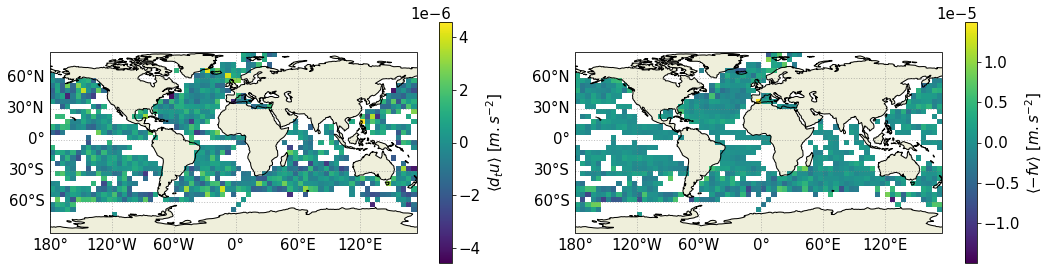

In [9]:
variables=['mean_drifter_acc_x','mean_drifter_coriolis_x',]
plot_stat_lonlat(variables, ds)

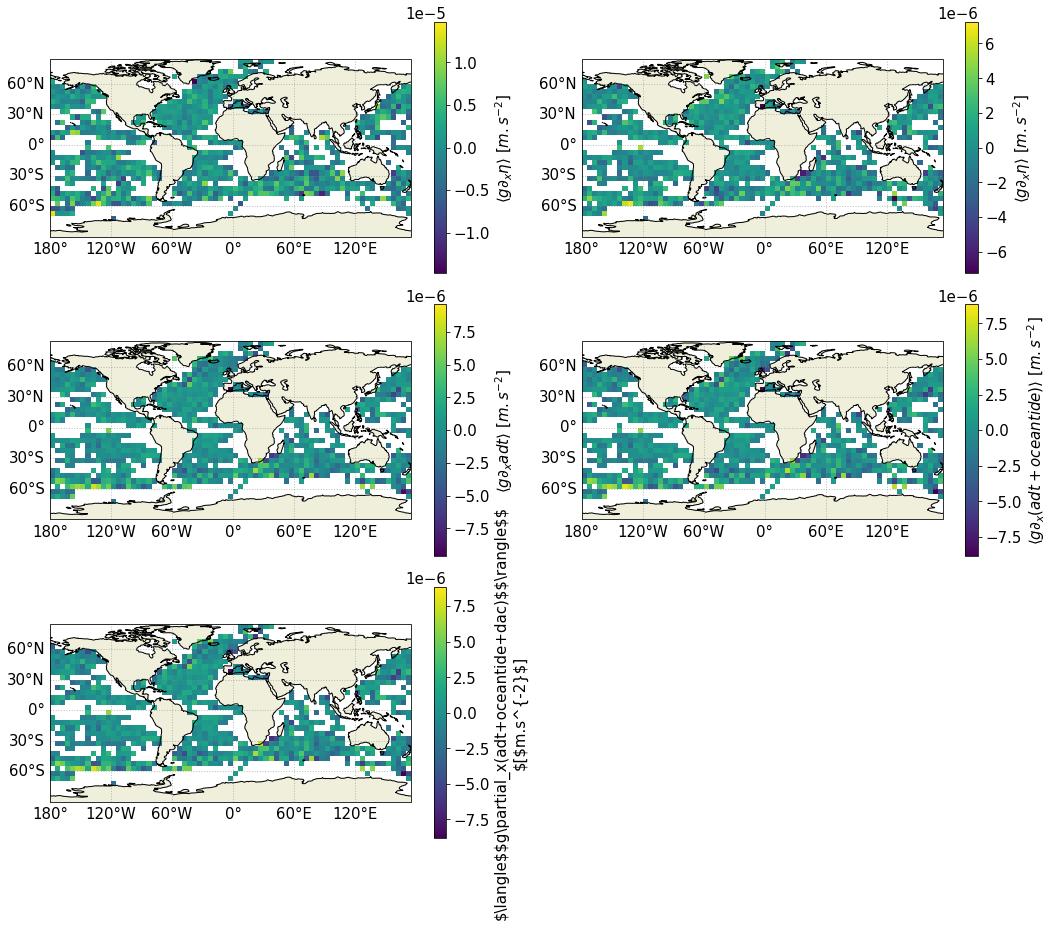

In [10]:
variables=['mean_alti_g_grad_x','mean_alti_denoised_g_grad_x','mean_alti_adt_g_grad_x','mean_alti_adt_oceantide_g_grad_x','mean_alti_adt_oceantide_dac_g_grad_x']
plot_stat_lonlat(variables, ds)

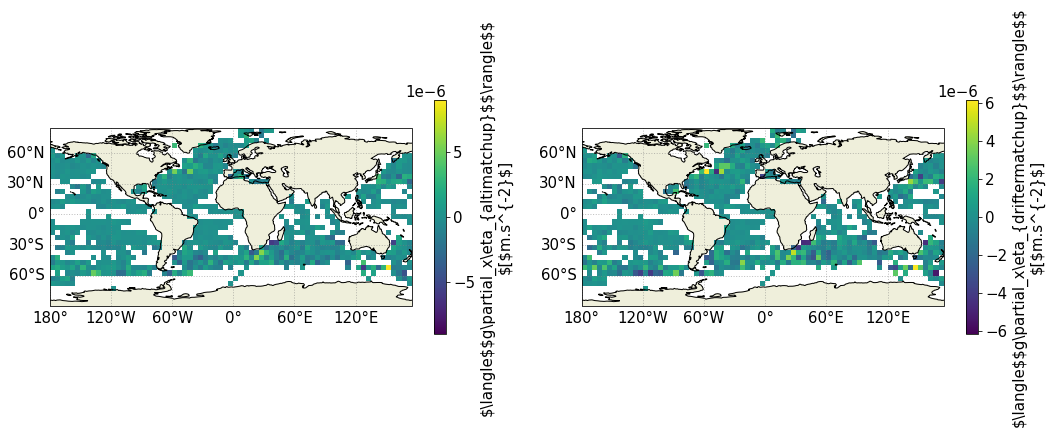

In [11]:
variables=['mean_aviso_alti_g_grad_x','mean_aviso_drifter_g_grad_x']
plot_stat_lonlat(variables, ds)

## Mean square $\langle --^2\rangle$

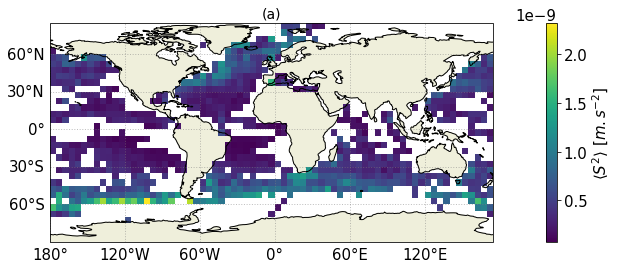

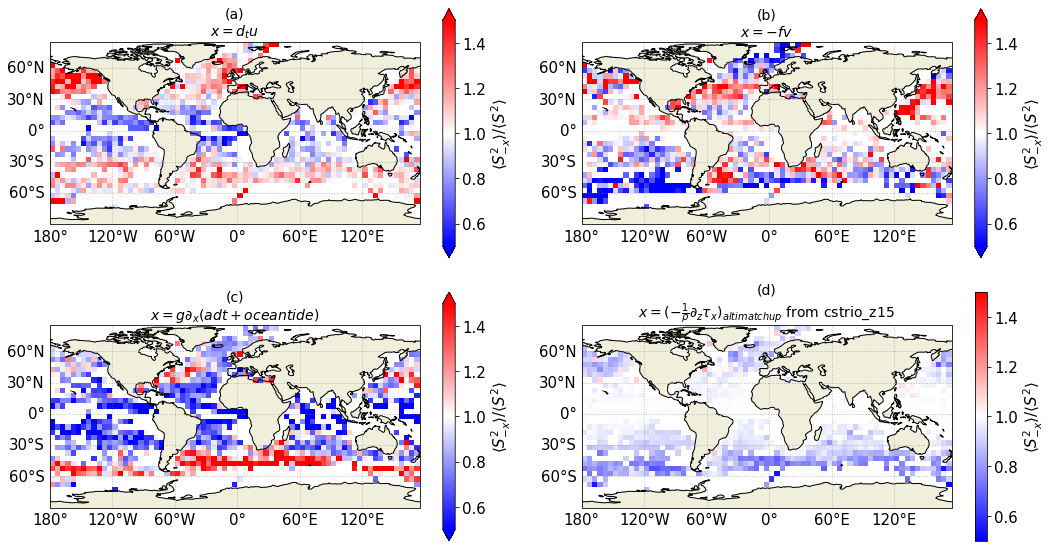

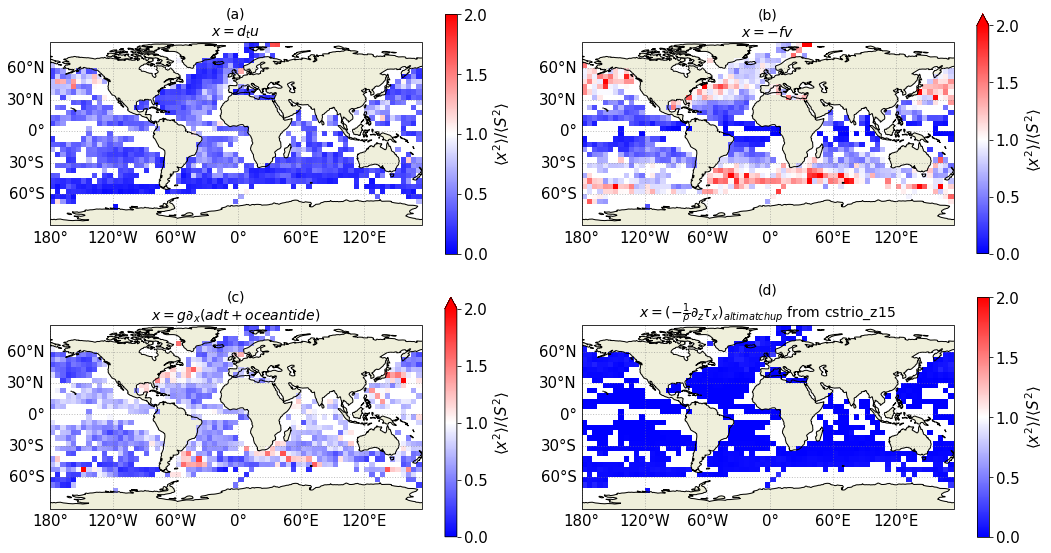

In [18]:
plot_ms_lonlat(ds, id_ = 'co_adt_oceantide_es_cstrio_z15_alti_x')

## Sum of all terms

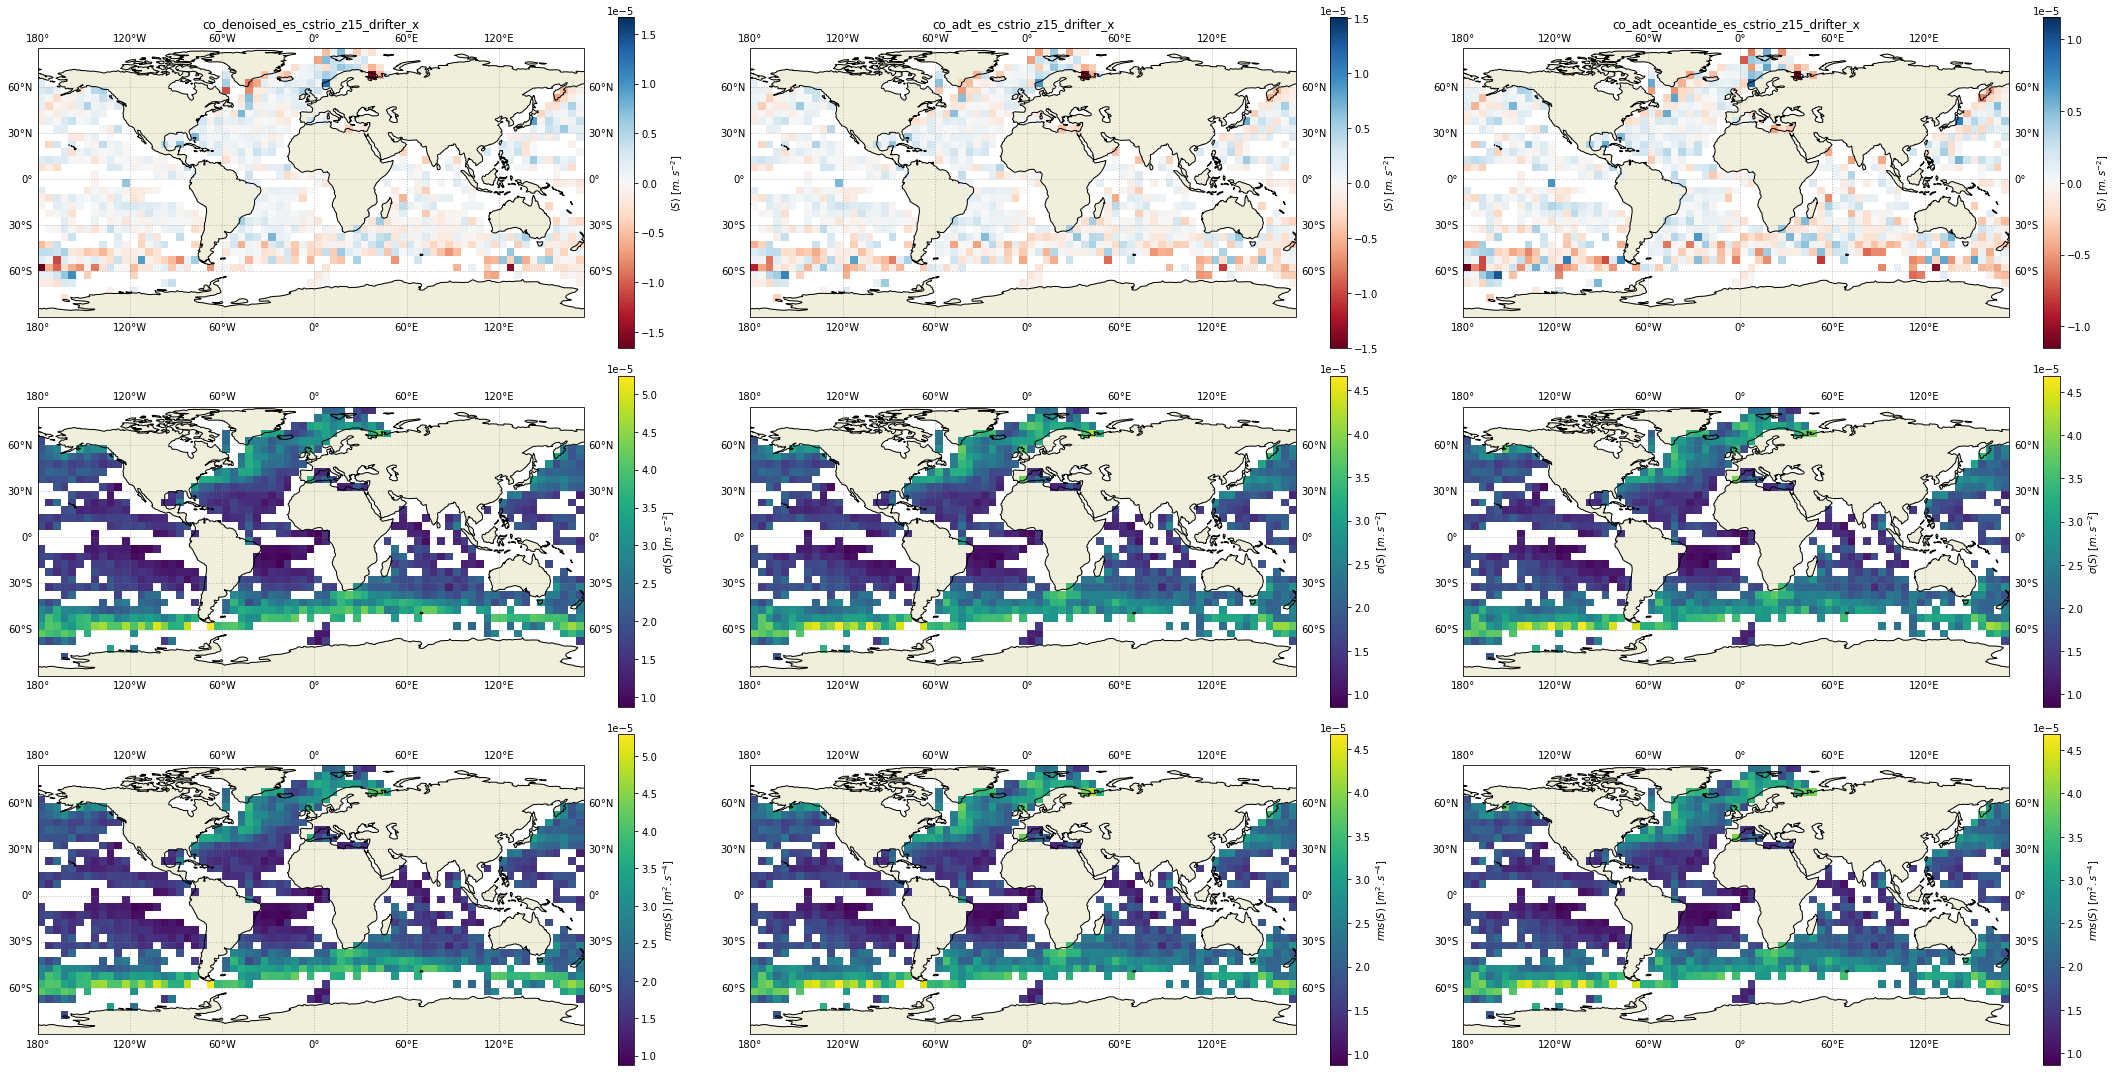

In [66]:
ID =['co_denoised_es_cstrio_z15_drifter_x','co_adt_es_cstrio_z15_drifter_x','co_adt_oceantide_es_cstrio_z15_drifter_x']
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=3,ncols=3,
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(30,15))
for i in range(len(ID)):
    ds['mean_sum_'+ID[i]].assign_attrs({'long_name':r'$ \langle S \rangle $'}).plot(x='lon_bin', y='lat_bin',cmap='RdBu', ax=axs[0,i])#, vmin=-2e-5, vmax=1.5e-5) 
    ds['std_sum_'+ID[i]].assign_attrs({'long_name':r'$ \sigma(S)$'}).plot(x='lon_bin', y='lat_bin',  cmap='viridis', ax=axs[1,i])#, vmax=5e-5)
    ds['rms_sum_'+ID[i]].assign_attrs({'long_name':r'$ rms(S)$'}).plot(x='lon_bin', y='lat_bin',  cmap='viridis', ax=axs[2,i])#, vmax=5e-5)
    axs[0,i].set_title(ID[i])
    
# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()    
# Draw the coastines for each subplot
for ax in axs:
            ax.coastlines()
            ax.add_feature(cfeature.LAND)
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle=':')

    
#fig.suptitle('Sum of all terms S')
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)

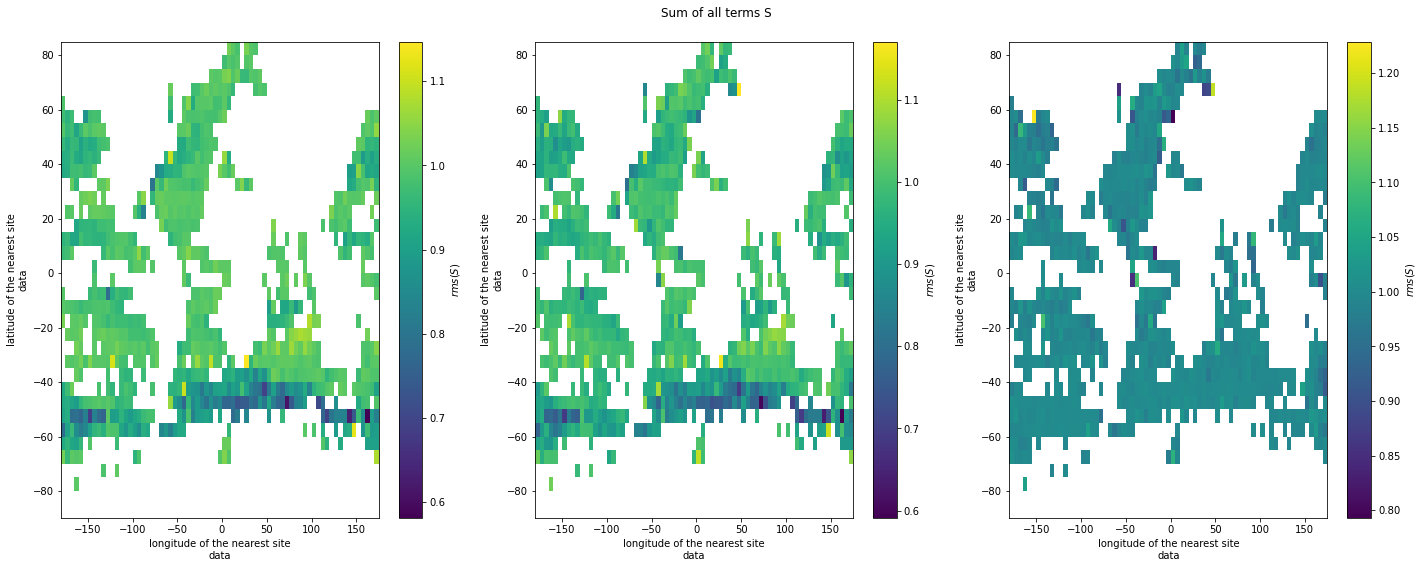

In [67]:
ID =['co_denoised_es_cstrio_z15_drifter_x','co_adt_es_cstrio_z15_drifter_x','co_adt_oceantide_es_cstrio_z15_drifter_x']

fig, ax = plt.subplots(1,3, figsize=(20,8 ))
(ds['rms_sum_'+ID[1]]/ds['rms_sum_'+ID[0]]).assign_attrs({'long_name':r'$ rms(S)$'}).plot(x='lon_bin', y='lat_bin',  cmap='viridis', ax=ax[0])
(ds['rms_sum_'+ID[2]]/ds['rms_sum_'+ID[0]]).assign_attrs({'long_name':r'$ rms(S)$'}).plot(x='lon_bin', y='lat_bin',  cmap='viridis', ax=ax[1])
(ds['rms_sum_'+ID[2]]/ds['rms_sum_'+ID[1]]).assign_attrs({'long_name':r'$ rms(S)$'}).plot(x='lon_bin', y='lat_bin',  cmap='viridis', ax=ax[2])
fig.suptitle('Sum of all terms S')
fig.tight_layout(rect=[0,0,1,0.98])#left, bottom, right, top (default is 0,0,1,1)

### Except sum


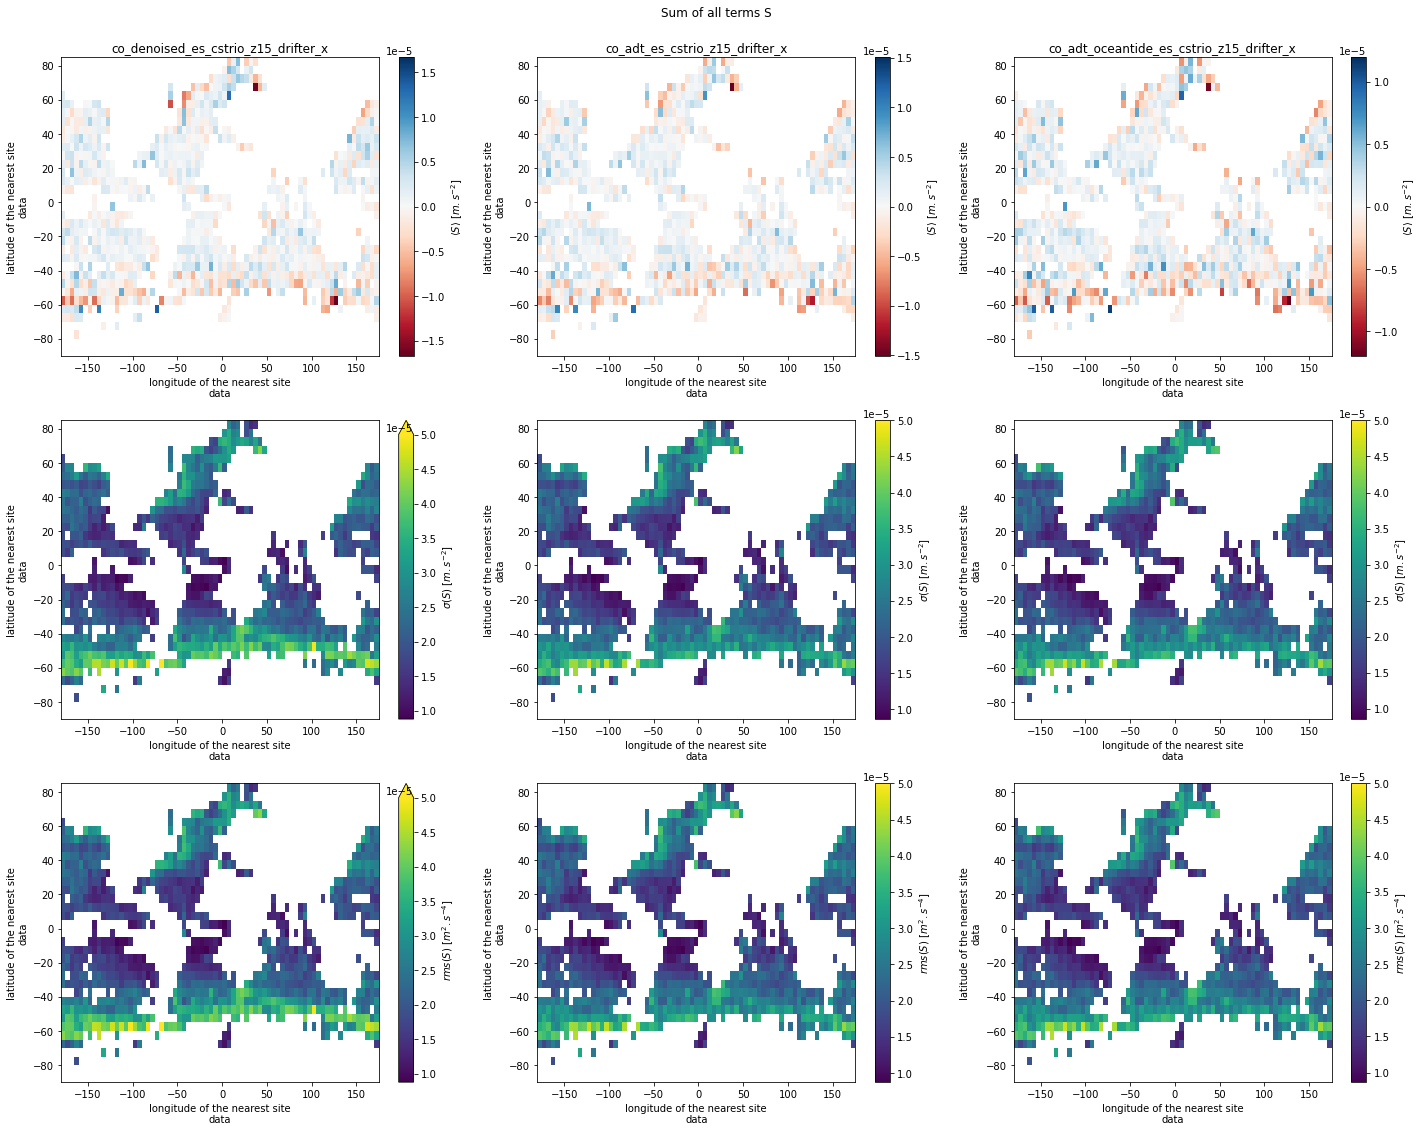

In [30]:
ID =['co_denoised_es_cstrio_z15_drifter_x','co_adt_es_cstrio_z15_drifter_x','co_adt_oceantide_es_cstrio_z15_drifter_x']

fig, ax = plt.subplots(3,len(ID), figsize=(20,16 ))
for i in range(len(ID)):
    ds['mean_sum_'+ID[i]].assign_attrs({'long_name':r'$ \langle S \rangle $'}).plot(x='lon_bin', y='lat_bin',cmap='RdBu', ax=ax[0,i])#, vmin=-2e-5, vmax=1.5e-5) 
    ds_std_all['mean_exc_acc_'+ID[i]].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax=vmax, ax=ax[0,i])
    ds_std_all['mean_exc_coriolis_'+ID[i]].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax=vmax, ax=ax[0,1])
    ds_std_all['mean_exc_ggrad_'+ID[i]].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax=vmax, ax=ax[1,0])
    ds_std_all['mean_exc_wind_'+ID[i]].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax=vmax, ax=ax[1,1])
    ds_std_all['mean_sum_'+ID[i]].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax =vmax ,ax=ax[2,0])
    ax[0,i].set_title(ID[i])
fig.suptitle('Sum of all terms S')
fig.tight_layout(rect=[0,0,1,0.98])#left, bottom, right, top (default is 0,0,1,1)

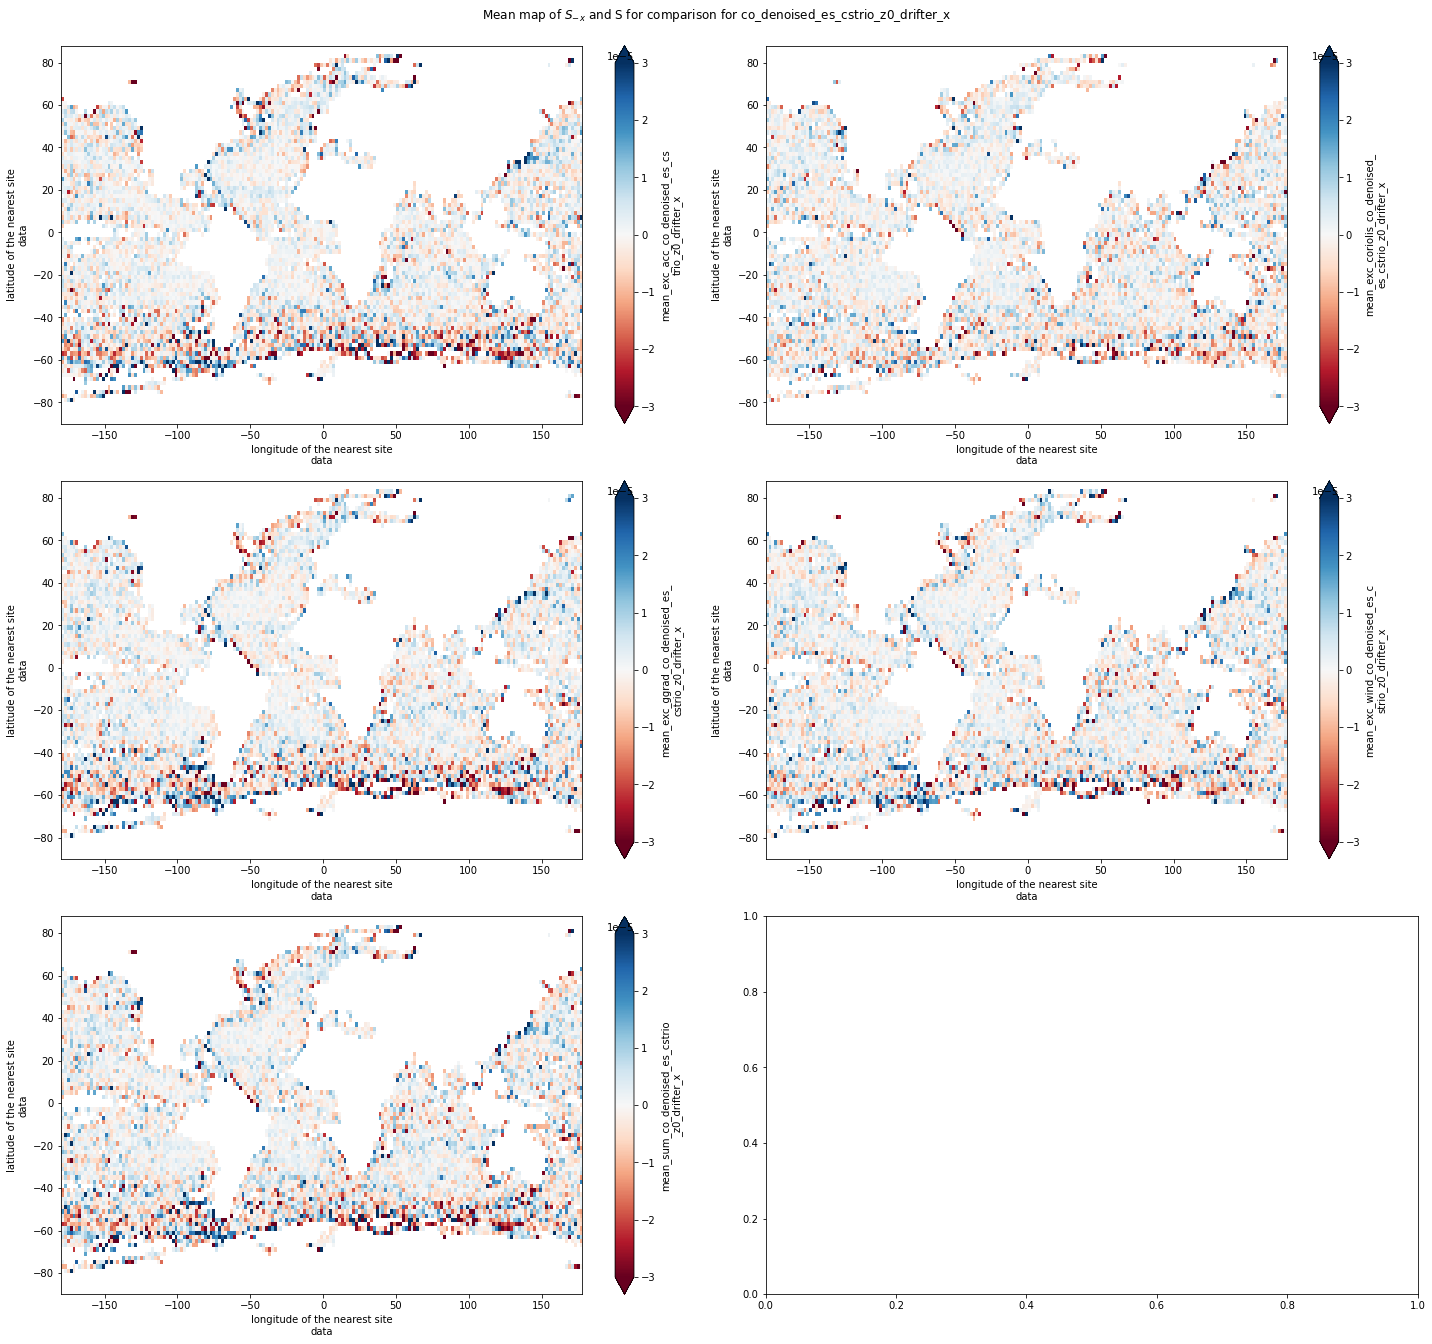

In [29]:
vmax=3e-5

fig, ax = plt.subplots(3,2, figsize=(20,19 ))
ds_std_all['mean_exc_acc_'+id_].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax=vmax, ax=ax[0,0])
ds_std_all['mean_exc_coriolis_'+id_].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax=vmax, ax=ax[0,1])
ds_std_all['mean_exc_ggrad_'+id_].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax=vmax, ax=ax[1,0])
ds_std_all['mean_exc_wind_'+id_].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax=vmax, ax=ax[1,1])
ds_std_all['mean_sum_'+id_].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax =vmax ,ax=ax[2,0])

#ds_repart_all.rename('nb_coloc/bin').plot(x='lon_bin', y='lat_bin', cmap='Set3', ax=ax[2,1])

fig.suptitle(r'Mean map of $S_{-x}$ and S for comparison for ' +id_)
fig.tight_layout(rect=[0,0,1,0.98])#left, bottom, right, top (default is 0,0,1,1)

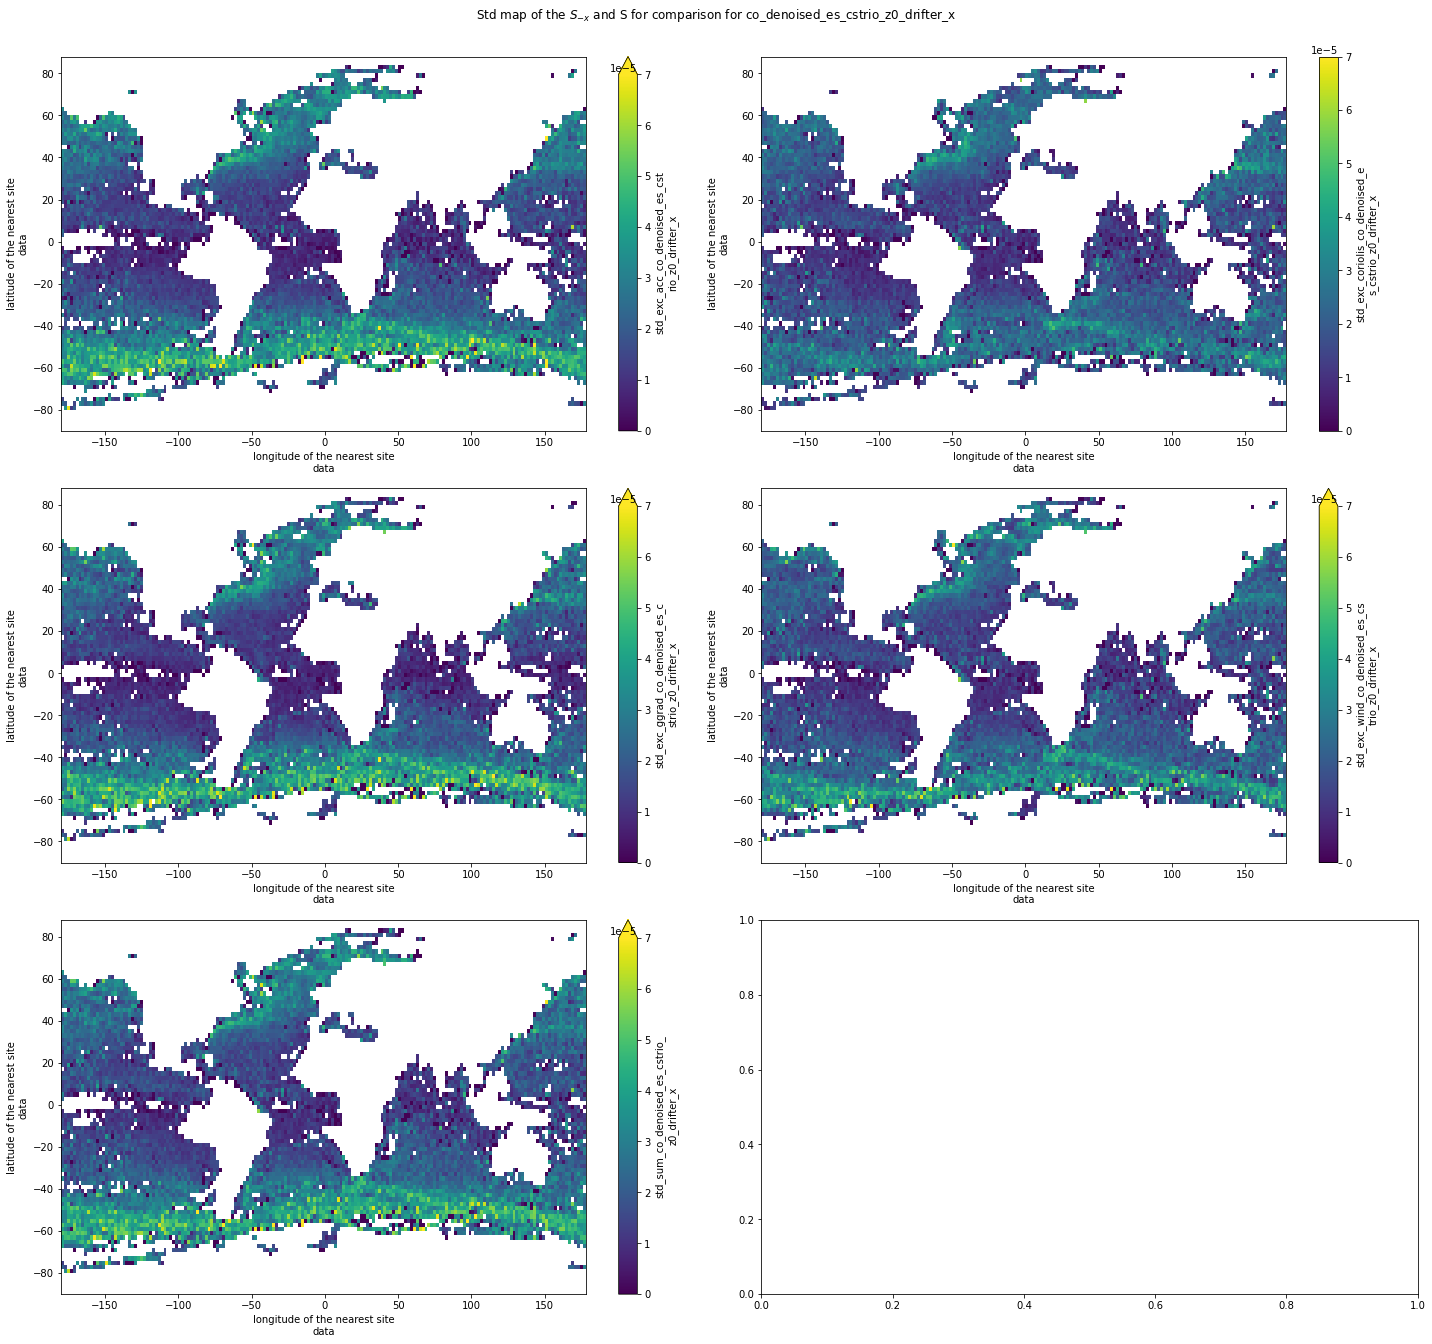

In [30]:
vmax=7e-5
fig, ax = plt.subplots(3,2, figsize=(20,19 ))
ds_std_all['std_exc_acc_'+id_].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax=vmax, ax=ax[0,0])
ds_std_all['std_exc_coriolis_'+id_].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax=vmax, ax=ax[0,1])
ds_std_all['std_exc_ggrad_'+id_].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax=vmax, ax=ax[1,0])
ds_std_all['std_exc_wind_'+id_].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax=vmax, ax=ax[1,1])
ds_std_all['std_sum_'+id_].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax =vmax ,ax=ax[2,0])

#ds_repart_all.rename('nb_coloc/bin').plot(x='lon_bin', y='lat_bin', cmap='Set3', ax=ax[2,1])

fig.suptitle(r'Std map of the $S_{-x}$ and S for comparison for ' +id_)
fig.tight_layout(rect=[0,0,1,0.98])#left, bottom, right, top (default is 0,0,1,1)

In [31]:
#id_ = 'co_es_cstrio_z0_drifter_x'
#ds_std_all['mean_exc_acc_'+id_].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis',vmin=-3.5e-5, vmax=3.5e-5,)

In [32]:
#id_ = 'co_es_cstrio_z0_drifter_x'
#ds_std_all['mean_exc_coriolis_'+id_].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis',vmin=-3.5e-5, vmax=3.5e-5,)

In [33]:
#id_ = 'co_es_cstrio_z0_drifter_x'
#ds_std_all['mean_exc_ggrad_'+id_].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis',vmin=-1.5e-5, vmax=1.5e-5,)

In [34]:
#id_ = 'co_es_cstrio_z0_drifter_x'
#ds_std_all['mean_exc_wind_'+id_].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis',vmin=-1.5e-5, vmax=1.5e-5,)

#### except std

In [35]:
#id_ = 'co_es_cstrio_z0_drifter_x'
#ds_std_all['std_exc_acc_'+id_].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis')#,vmin=-1.5e-5, vmax=1.5e-5,)

In [36]:
#id_ = 'co_es_cstrio_z0_drifter_x'
#ds_std_all['mean_exc_coriolis_'+id_].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis',vmin=-2e-5, vmax=1.5e-5,)

## STD and mean values map for erastar 0m, drifter matchup, grad aviso
### mean sum of all

Text(0.5, 1.0, 'Mean of S for aviso_es_cstrio_z0_drifter_x')

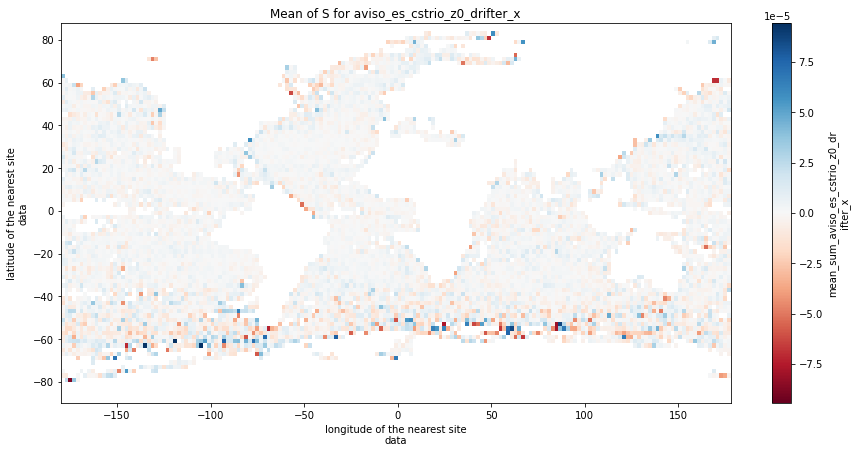

In [37]:
id_2 = 'aviso_es_cstrio_z0_drifter_x'
ds_std_all['mean_sum_'+id_2].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='RdBu')#,vmin=-1.5e-5, vmax=1.5e-5,)
plt.title('Mean of S for ' +id_2)

Text(0.5, 1.0, 'Mean of S for aviso_es_cstrio_z0_drifter_x')

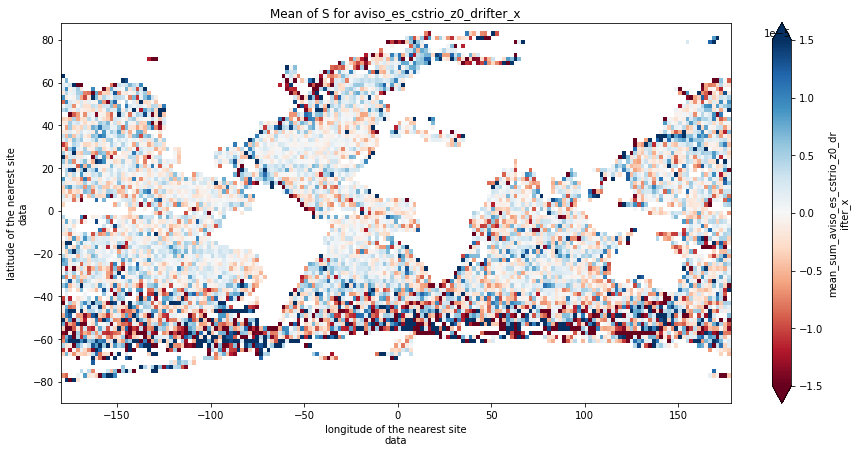

In [38]:
id_2 = 'aviso_es_cstrio_z0_drifter_x'
ds_std_all['mean_sum_'+id_2].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='RdBu',vmin=-1.5e-5, vmax=1.5e-5,)
plt.title('Mean of S for ' +id_2)

Text(0.5, 1.0, 'Std of S for aviso_es_cstrio_z0_drifter_x')

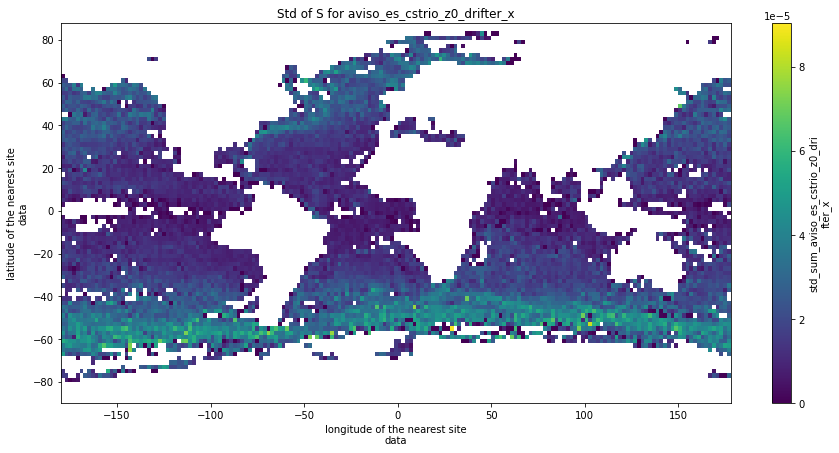

In [39]:
ds_std_all['std_sum_'+id_2].plot(x='lon_bin', y='lat_bin', figsize=(15,7), cmap='viridis')#,vmin=-1.5e-5, vmax=1.5e-5,)
plt.title('Std of S for ' +id_2)

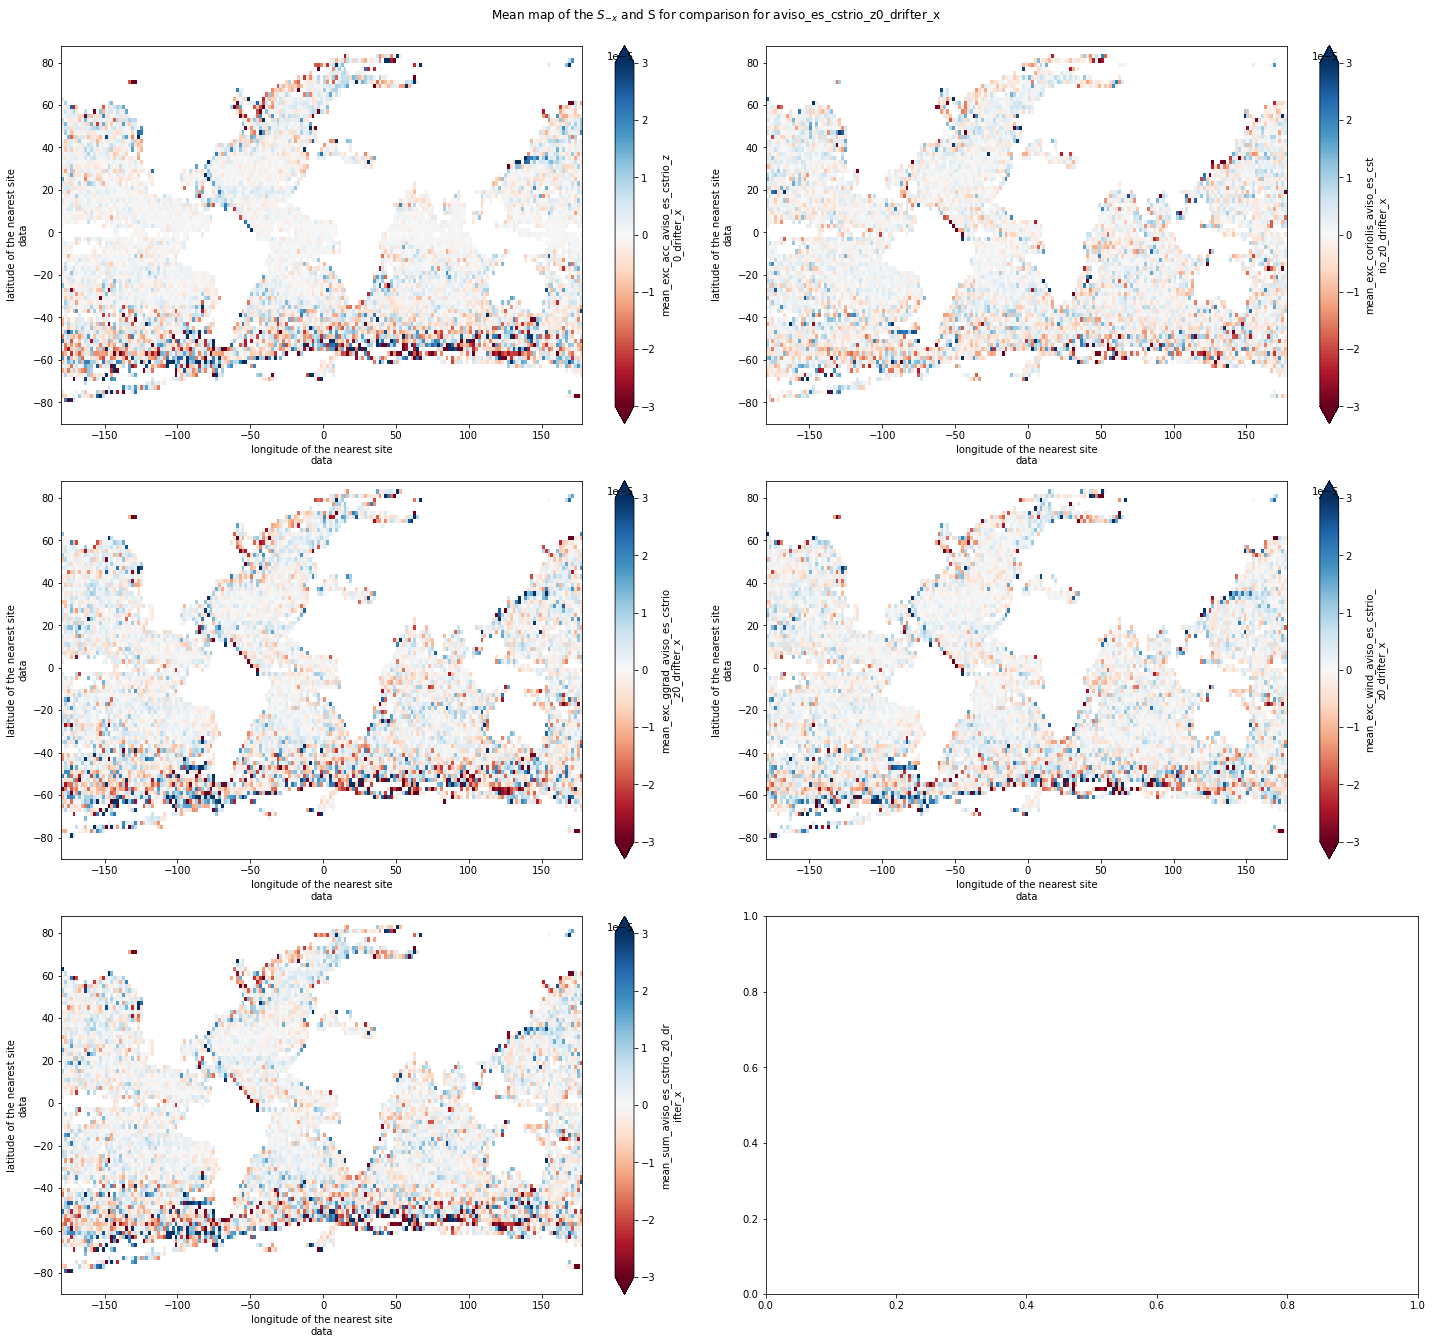

In [40]:
vmax=3e-5
fig, ax = plt.subplots(3,2, figsize=(20,19 ))
ds_std_all['mean_exc_acc_'+id_2].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax=vmax, ax=ax[0,0])
ds_std_all['mean_exc_coriolis_'+id_2].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax=vmax, ax=ax[0,1])
ds_std_all['mean_exc_ggrad_'+id_2].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax=vmax, ax=ax[1,0])
ds_std_all['mean_exc_wind_'+id_2].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax=vmax, ax=ax[1,1])
ds_std_all['mean_sum_'+id_2].plot(x='lon_bin', y='lat_bin', cmap='RdBu', vmax =vmax ,ax=ax[2,0])

#ds_repart_all.rename('nb_coloc/bin').plot(x='lon_bin', y='lat_bin', cmap='Set3', ax=ax[2,1])

fig.suptitle(r'Mean map of the $S_{-x}$ and S for comparison for ' +id_2)
fig.tight_layout(rect=[0,0,1,0.98])#left, bottom, right, top (default is 0,0,1,1)

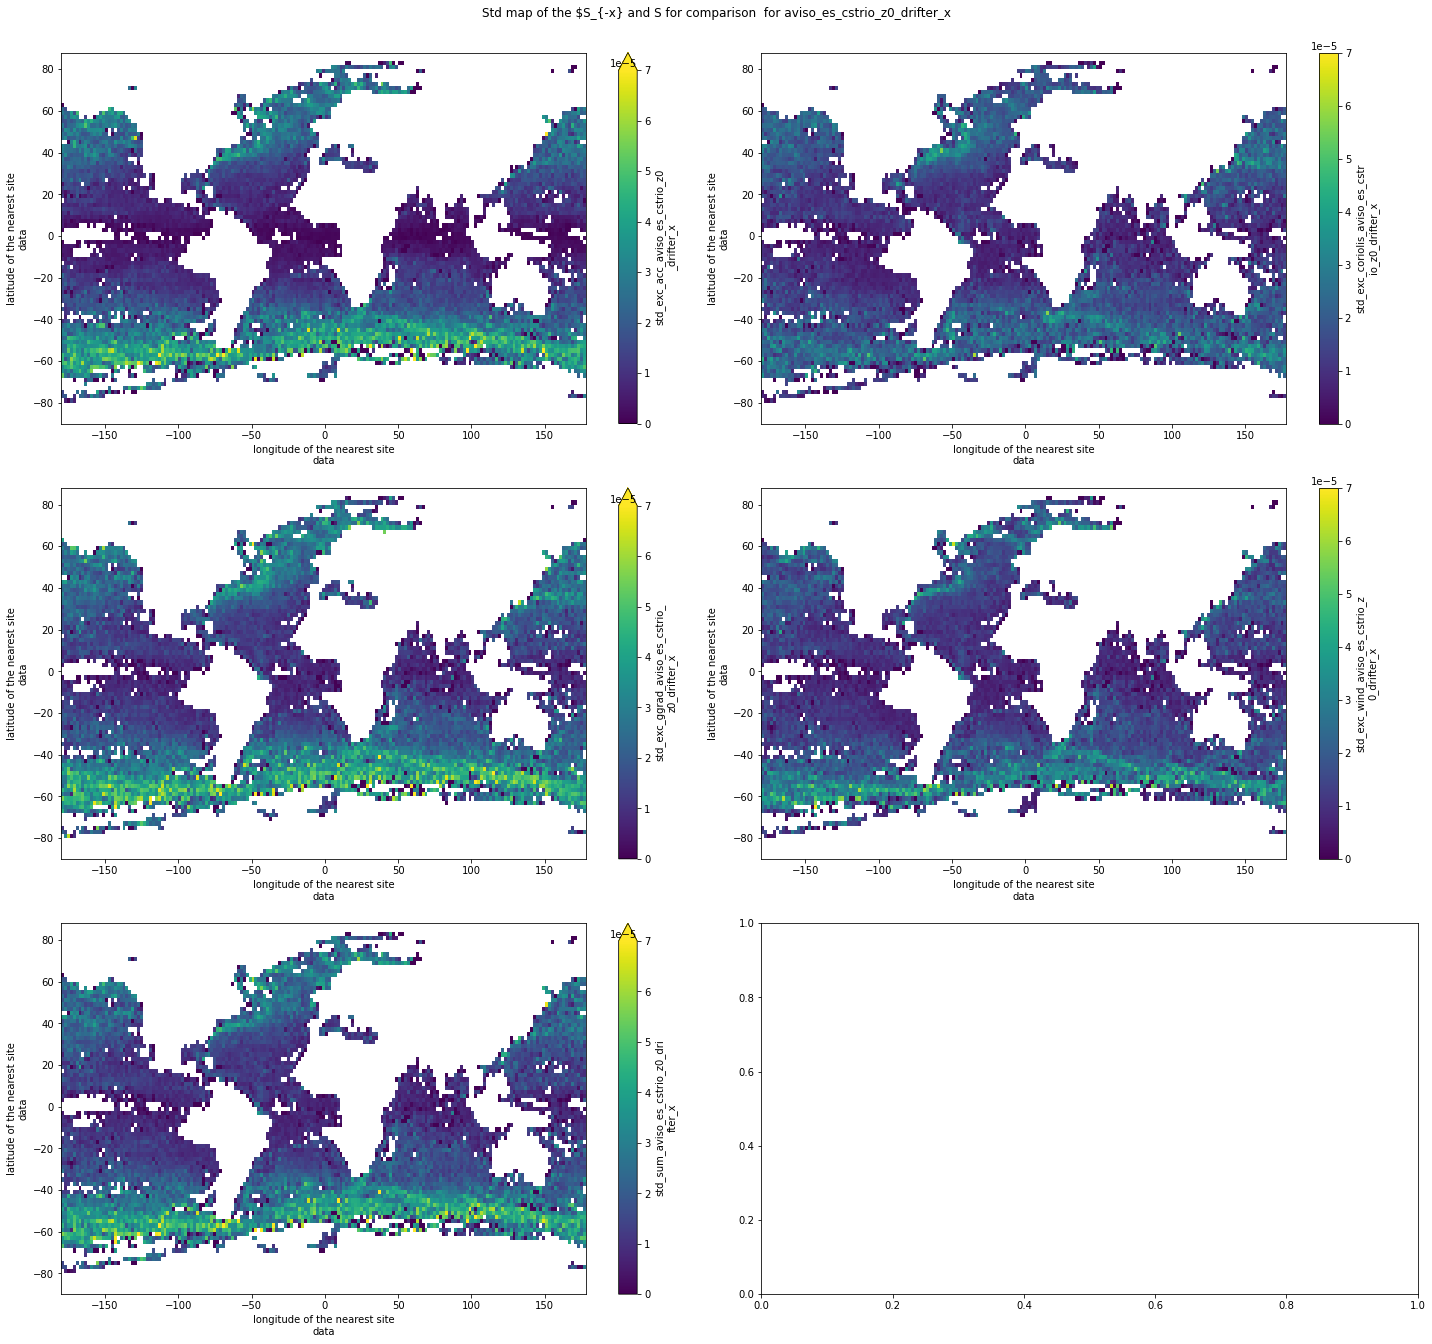

In [41]:
vmax=7e-5
fig, ax = plt.subplots(3,2, figsize=(20,19 ))
ds_std_all['std_exc_acc_'+id_2].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax=vmax, ax=ax[0,0])
ds_std_all['std_exc_coriolis_'+id_2].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax=vmax, ax=ax[0,1])
ds_std_all['std_exc_ggrad_'+id_2].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax=vmax, ax=ax[1,0])
ds_std_all['std_exc_wind_'+id_2].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax=vmax, ax=ax[1,1])
ds_std_all['std_sum_'+id_2].plot(x='lon_bin', y='lat_bin', cmap='viridis', vmax =vmax ,ax=ax[2,0])

#ds_repart_all.rename('nb_coloc/bin').plot(x='lon_bin', y='lat_bin', cmap='Set3', ax=ax[2,1])

fig.suptitle(r'Std map of the $S_{-x} and S for comparison  for ' +id_2)
fig.tight_layout(rect=[0,0,1,0.98])#left, bottom, right, top (default is 0,0,1,1)

In [19]:
cluster.close()